In [13]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

zip_filename = 'features.zip'
extract_path = '/content/features_data'

# Check and Unzip
if os.path.exists(zip_filename):
    if not os.path.exists(extract_path):
        print(f"Unzipping {zip_filename}...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    else:
        print("Files already extracted.")
else:
    print(f"ERROR: '{zip_filename}' not found! Please upload it to the Files sidebar.")

uid_excel = 'mos_UID.xlsx'
saud_excel = 'SAUD_MOS.xlsx'
feature_root = os.path.abspath(extract_path)

X, y = [], []

def clean_name(fname):
    return fname.strip("'").strip() if isinstance(fname, str) else fname

# --- Load UID ---
if os.path.exists(uid_excel):
    try:
        df = pd.read_excel(uid_excel)
        uid_map = dict(zip(df['Name'], df['MOS']))
        all_files = glob.glob(os.path.join(feature_root, '**', '*.mat'), recursive=True)
        count = 0
        for fpath in all_files:
            img_name = os.path.splitext(os.path.basename(fpath))[0] + ".png"
            if img_name in uid_map:
                try:
                    mat = scipy.io.loadmat(fpath)
                    if 'features' in mat:
                        feat = mat['features'].flatten()
                        if feat.shape[0] == 25:
                            X.append(feat)
                            y.append(uid_map[img_name])
                            count += 1
                except: pass
        print(f"UID Data: Loaded {count} samples.")
    except: print("Error reading UID Excel.")

# --- Load SAUD ---
if os.path.exists(saud_excel):
    try:
        df = pd.read_excel(saud_excel)
        df['clean'] = df['Name'].apply(clean_name)
        saud_map = dict(zip(df['clean'], df['MOS']))
        all_files = glob.glob(os.path.join(feature_root, '**', '*.mat'), recursive=True)
        count = 0
        for fpath in all_files:
            parts = fpath.replace('\\', '/').split('/')
            if len(parts) > 3:
                name = os.path.splitext(parts[-1])[0] + ".png"
                key = f"{parts[-3]}/{parts[-2]}/{name}"
                score = saud_map.get(key) or saud_map.get(name)
                if score is not None:
                    try:
                        mat = scipy.io.loadmat(fpath)
                        if 'features' in mat:
                            feat = mat['features'].flatten()
                            if feat.shape[0] == 25:
                                X.append(feat)
                                y.append(score)
                                count += 1
                    except: pass
        print(f"SAUD Data: Loaded {count} samples.")
    except: print("Error reading SAUD Excel.")

X = np.array(X)
y = np.array(y)
print(f"\nTOTAL DATA: {len(X)} samples loaded.")

Files already extracted.
UID Data: Loaded 960 samples.
SAUD Data: Loaded 1000 samples.

TOTAL DATA: 1960 samples loaded.


**simulation engine**

In [14]:
from sklearn.model_selection import ParameterGrid
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

ITERATIONS = 500

def run_simulation(model_class, param_grid, X, y, n_iters=10, scale=False, model_name="Model"):
    """
    Runs repeated random sub-sampling validation.
    """
    metrics = {'PLCC': [], 'SRCC': [], 'KRCC': [], 'RMSE': []}
    print(f"Starting {n_iters} iterations for {model_name}...")

    for i in tqdm(range(n_iters)):
        # 1. Random Split (80% Train+Val, 20% Test)
        X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.20, random_state=None)

        # 2. Validation Split (12.5% of 80% = 10% of total)
        X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.125, random_state=None)

        # 3. Scaling (Only if scale=True, mostly for SVR)
        if scale:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            X_train_p = scaler.fit_transform(X_train)
            X_val_p = scaler.transform(X_val)
            X_test_p = scaler.transform(X_test)
        else:
            X_train_p, X_val_p, X_test_p = X_train, X_val, X_test

        # 4. Grid Search
        best_score = -2
        best_model = None

        if not param_grid:
            model = model_class()
            model.fit(X_train_p, y_train)
            best_model = model
        else:
            for params in ParameterGrid(param_grid):
                model = model_class(**params)
                model.fit(X_train_p, y_train)
                # Validation Metric: SRCC
                srcc, _ = spearmanr(y_val, model.predict(X_val_p))
                if srcc > best_score:
                    best_score = srcc
                    best_model = model

        # 5. Final Test
        test_preds = best_model.predict(X_test_p)
        metrics['PLCC'].append(pearsonr(y_test, test_preds)[0])
        metrics['SRCC'].append(spearmanr(y_test, test_preds)[0])
        metrics['KRCC'].append(kendalltau(y_test, test_preds)[0])
        metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, test_preds)))

    return {k: np.mean(v) for k, v in metrics.items()}

**Support Vector Regression Method**

In [15]:
from sklearn.svm import SVR

# Hyperparameters to tune
param_svr = {
    'C': [10, 50, 100],
    'gamma': ['scale', 0.1],
    'epsilon': [0.1]
}

# Run Simulation
svr_avg = run_simulation(
    SVR,
    param_svr,
    X, y,
    n_iters=ITERATIONS,
    scale=True,
    model_name="SVR"
)

print(f"SVR Result: {svr_avg}")

Starting 500 iterations for SVR...


  0%|          | 0/500 [00:00<?, ?it/s]

SVR Result: {'PLCC': np.float64(0.7860902804540547), 'SRCC': np.float64(0.7892942920625056), 'KRCC': np.float64(0.595552159769306), 'RMSE': np.float64(1.7714651468371068)}


**Random Forest Regression Method**

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters
param_rf = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'n_jobs': [-1]
}

# Run Simulation
rf_avg = run_simulation(
    RandomForestRegressor,
    param_rf,
    X, y,
    n_iters=ITERATIONS,
    scale=False,
    model_name="Random Forest"
)

print(f"RF Result: {rf_avg}")

Starting 500 iterations for Random Forest...


  0%|          | 0/500 [00:00<?, ?it/s]

RF Result: {'PLCC': np.float64(0.8157159075163645), 'SRCC': np.float64(0.8128243889408), 'KRCC': np.float64(0.6284604377858807), 'RMSE': np.float64(1.6557478933395378)}


**AdaBoost Regressor**

In [17]:
from sklearn.ensemble import AdaBoostRegressor

# Hyperparameters
param_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['linear', 'square'],
    'random_state': [None]
}

# Run Simulation
ada_avg = run_simulation(
    AdaBoostRegressor,
    param_ada,
    X, y,
    n_iters=ITERATIONS,
    scale=False,
    model_name="AdaBoost"
)

print(f"AdaBoost Result: {ada_avg}")

Starting 500 iterations for AdaBoost...


  0%|          | 0/500 [00:00<?, ?it/s]

AdaBoost Result: {'PLCC': np.float64(0.7422740731055241), 'SRCC': np.float64(0.7369592482908306), 'KRCC': np.float64(0.5448989595334983), 'RMSE': np.float64(1.9296058757163752)}


**Gradient Boosting Regressor**

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameters
param_gbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8]
}

# Run Simulation
gbm_avg = run_simulation(
    GradientBoostingRegressor,
    param_gbm,
    X, y,
    n_iters=ITERATIONS,
    scale=False,
    model_name="Gradient Boosting"
)

print(f"GBM Result: {gbm_avg}")

Starting 500 iterations for Gradient Boosting...


  0%|          | 0/500 [00:00<?, ?it/s]

GBM Result: {'PLCC': np.float64(0.8155397876792412), 'SRCC': np.float64(0.8091943822698336), 'KRCC': np.float64(0.6210753308454044), 'RMSE': np.float64(1.6497999803213739)}


**XGBoost Regressor**

In [19]:
import xgboost as xgb

# Hyperparameters
param_xgb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'objective': ['reg:squarederror'],
    'n_jobs': [-1]
}

# Run Simulation
xgb_avg = run_simulation(
    xgb.XGBRegressor,
    param_xgb,
    X, y,
    n_iters=ITERATIONS,
    scale=False,
    model_name="XGBoost"
)

print(f"XGBoost Result: {xgb_avg}")

Starting 500 iterations for XGBoost...


  0%|          | 0/500 [00:00<?, ?it/s]

XGBoost Result: {'PLCC': np.float64(0.8177207135180002), 'SRCC': np.float64(0.8107862468861181), 'KRCC': np.float64(0.6221434619840981), 'RMSE': np.float64(1.6432231213798922)}


**Final Comparison**


FINAL PERFORMANCE (Average of 500 Iterations)
                  PLCC    SRCC    KRCC    RMSE
SVR             0.7861  0.7893  0.5956  1.7715
Random Forest   0.8157  0.8128  0.6285  1.6557
AdaBoost        0.7423  0.7370  0.5449  1.9296
Gradient Boost  0.8155  0.8092  0.6211  1.6498
XGBoost         0.8177  0.8108  0.6221  1.6432


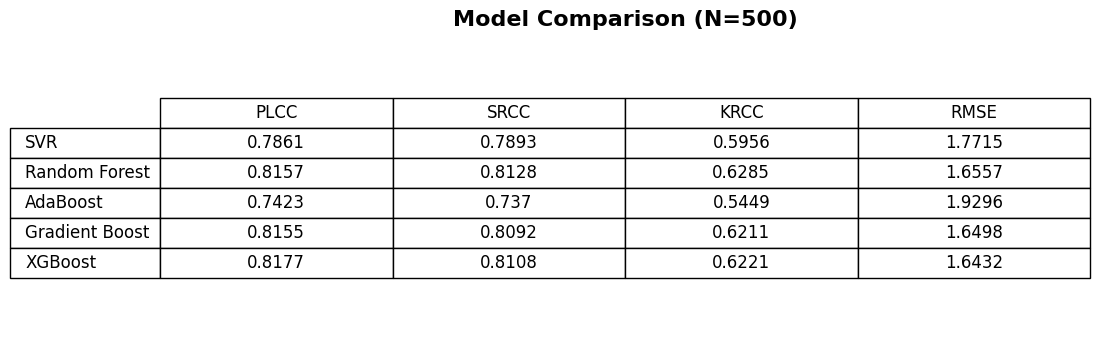

In [20]:
# Create DataFrame
results_df = pd.DataFrame(
    [svr_avg, rf_avg, ada_avg, gbm_avg, xgb_avg],
    index=['SVR', 'Random Forest', 'AdaBoost', 'Gradient Boost', 'XGBoost']
)
results_df = results_df[['PLCC', 'SRCC', 'KRCC', 'RMSE']] # Reorder columns

# 1. Print Text Table
print("\n" + "="*50)
print(f"FINAL PERFORMANCE (Average of {ITERATIONS} Iterations)")
print("="*50)
print(results_df.round(4))
print("="*50)

# 2. Generate Graphic Table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

table_data = results_df.round(4)
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    rowLabels=table_data.index,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8) # Adjust size

plt.title(f"Model Comparison (N={ITERATIONS})", fontsize=16, weight='bold')
plt.show()